In [1]:
import sys
import os
sys.path.append(os.path.abspath("../"))  # or "../../" depending on location

In [2]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader
from utils.likelihood import *
from utils.formate_matrix_toMLData import *
from models.model_0929 import *
import matplotlib.pyplot as plt
import japanize_matplotlib
plt.rcParams["font.size"] = 22
np.set_printoptions(suppress=True)


In [3]:

device = torch.device("cpu")
model = DeepSets_varSets_forDiagnel(device=device).to(device)
model.load_state_dict(torch.load("../model_weights/mixed_distribution/mixed_0929.pth", map_location=device))
model.eval()

/var/folders/k3/b1t1gjg12pg0ycfdgpm2k7g00000gn/T/ipykernel_82313/3362759427.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("../model_we

DeepSets_varSets_forDiagnel(
  (embedding): Embedding(5, 16, padding_idx=0)
  (fc1): Linear(in_features=33, out_features=256, bias=True)
  (ln1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (fc2): Linear(in_features=256, out_features=512, bias=True)
  (ln2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (drop): Dropout(p=0.2, inplace=False)
  (att_fc): Linear(in_features=512, out_features=512, bias=True)
  (att_score): Linear(in_features=512, out_features=1, bias=True)
  (out_fc1): Linear(in_features=512, out_features=128, bias=True)
  (out_ln1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (out_fc2): Linear(in_features=128, out_features=64, bias=True)
  (out_ln2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  (out_fc3): Linear(in_features=64, out_features=3, bias=True)
)

In [4]:
data_name = "suidou"
real_data_dir = f"../real_data/{data_name}.csv"
if data_name == "RCBridge":
    df = pd.read_csv(real_data_dir, delimiter=",",header = None)
else:
    df = pd.read_csv(real_data_dir, delimiter=",")
display(df.head())
print(df.columns)

,経過年数,建設時健全度（1と仮定）,調査時健全度,定数項（x1＝1）,管径,管渠延長,スパンID,調査年,建設年,材質番号（1 ヒューム管）
0,16,1,1,1,0.151515,0.199762,10987002,2013,1997,1
1,16,1,2,1,0.151515,0.123857,10988012,2013,1997,1
2,16,1,2,1,0.151515,0.145714,10997005,2013,1997,1
3,14,1,3,1,0.151515,0.183333,10997015,2013,1999,1
4,14,1,1,1,0.151515,0.119762,10997027,2013,1999,1


Index(['経過年数', '建設時健全度（1と仮定）', '調査時健全度', '定数項（x1＝1）', '管径', '管渠延長', 'スパンID',
       '調査年', '建設年', '材質番号（1 ヒューム管）'],
      dtype='object')


In [5]:
if data_name == "suidou":
    df = df.rename(columns={'建設時健全度（1と仮定）': "pre", '調査時健全度': "post", '経過年数': "time"})
if data_name == "shoban":
    df = df.rename(columns={'Be(1-4)': "pre", 'Af(1-4)': "post", 'Ins': "time"})
if data_name == "Frank":
    def grading(x):
        if x <= 30:
            return 1
        elif x <= 50:
            return 2
        elif x <= 70:
            return 3
        else: 4
    df["Post_IRI_Class"] = df['Post-State IRI'].apply(grading)
    df["Pre_IRI_Class"] = df['Pre-State IRI'].apply(grading)
    df["time"] = df['Inspection Time of PostState IRI']-df['Inspection Time of Prestate']
    df = df.rename(columns={'Pre_IRI_Class': "pre", 'Post_IRI_Class': "post"})
if data_name == "Tunnel":
    df = df.rename(columns={'事前健全度': "pre", '事後健全度': "post", '検査間隔(年)': "time"})
    df = df[["pre", "post", "time"]]
    df = df.dropna()
    df["pre"] = df["pre"].astype(int)
    df["post"] = df["post"].astype(int)
    df = df[df["time"] < 8]

if data_name == "RCBridge":
    df = df.rename(columns={0: "pre", 1: "post", 2: "time"})
    df = df[df["pre"] < 4]
    df = df[df["post"] < 5]

In [6]:
display(df.head())

,time,pre,post,定数項（x1＝1）,管径,管渠延長,スパンID,調査年,建設年,材質番号（1 ヒューム管）
0,16,1,1,1,0.151515,0.199762,10987002,2013,1997,1
1,16,1,2,1,0.151515,0.123857,10988012,2013,1997,1
2,16,1,2,1,0.151515,0.145714,10997005,2013,1997,1
3,14,1,3,1,0.151515,0.183333,10997015,2013,1999,1
4,14,1,1,1,0.151515,0.119762,10997027,2013,1999,1


4343


Text(0.5, 1.0, 'suidouの点検間隔分布')

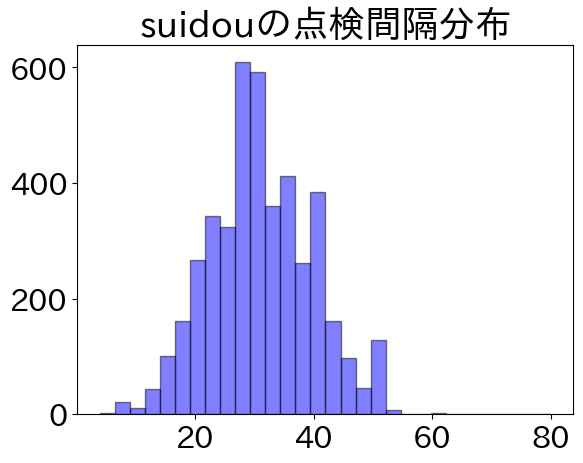

In [7]:
df = df[["pre", "post", "time"]]
# df = df[df["pre"] < 4]
# df = df[df["post"] < 5]
print(len(df))
r =1
plt.hist(df["time"], bins=30, alpha=0.5, color="blue", edgecolor="black", zorder= 2)
plt.title(f"{data_name}の点検間隔分布")

In [8]:
# likelihood process
state = np.array([df["pre"],df["post"]])
del_t = np.array(df["time"]/r)

data = np.column_stack((state.T,del_t.T))
ll = Likelihood_diagonal_exp(data)
Q = ll.optimize(np.array([-0.5,-1,-1.5]))
formater = formate_dataMatrix()
vec = formater.GetOutputVector_byDiagonal(Q)

In [9]:
dataset = varSets_Datasets([state],[del_t], [vec])
dataloader = DataLoader(dataset, batch_size=1,shuffle=False,collate_fn=collate_fn)
pred = []
expect = []
for a, b, c,d in dataloader:
    with torch.no_grad():
        out = model(a, b, d)
        pred = 1/out
        expect = 1/c
    print(f"output is {out}")
    print(f"target is {c}")
    print(1/out * r)
    print(1/c * r)

output is tensor([[0.0445, 0.0520, 0.0237]])
target is tensor([[0.0448, 0.0530, 0.0258]])
tensor([[22.4629, 19.2255, 42.2695]])
tensor([[22.3031, 18.8850, 38.6929]])


pred by 0911
output is tensor([[0.0600, 0.0434, 0.0229]])
target is tensor([[0.0448, 0.0530, 0.0258]])
tensor([[16.6536, 23.0492, 43.7582]])
tensor([[22.3031, 18.8850, 38.6929]])

代理モデルによる劣化推移予測


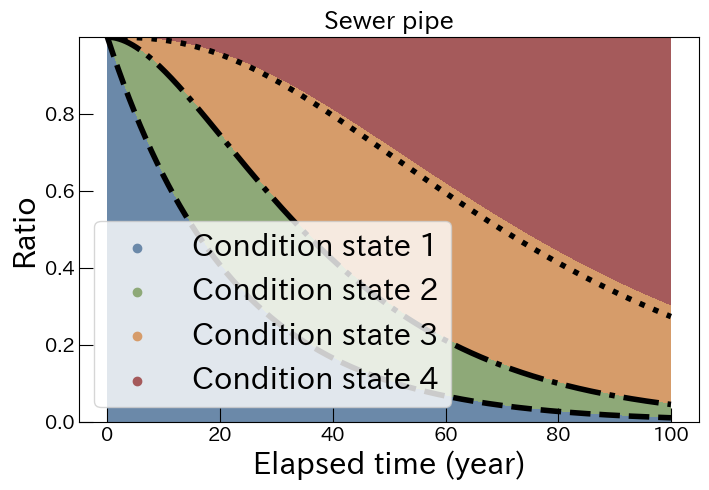

In [11]:
colors= ['#6b89a9', '#8ea978', '#d69c6a', '#a55a5b'] #彩度下げ冷暖色
plt.rcParams["figure.figsize"] = (8, 5)

sequence = np.arange(0, 100, 0.01)
def visualize(Q,title):
    vecs = []
    for t in sequence:
        P = expm(Q * t)
        vecs.append(P[0])
    
    for i, vec in enumerate(vecs):
        bottom = 0
        # vec = vec[::-1]
    
        for j, value in enumerate(vec):
            plt.bar(sequence[i], value, bottom=bottom, color=colors[j],width=0.01)
            bottom += value
    for i in range(len(colors)):
        plt.scatter([],[], color = colors[i],label = f"Condition state {i+1}")
    vecs = np.array(vecs)
    
    plot_trueline(c[0])
    plt.tick_params(axis='x', labelsize=14, direction='in', length=10)
    plt.tick_params(axis='y', labelsize=14, direction='in', length=10)
    plt.xlabel("Elapsed time (year)", fontsize = 22)
    plt.ylabel("Ratio", fontsize = 22)
    plt.title(title, fontsize = 18)
    plt.legend(loc = "lower left")
    plt.show()
    
def generate_Q_from_diagonal(vec):
        Q = np.zeros((4,4))
        for i in range(len(vec)):
            Q[i,i+1]= vec[i]
            Q[i,i] = -Q[i,i+1]
        return Q
def plot_trueline(vec):
    true_vecs = []
    true_Q = generate_Q_from_diagonal(vec/r)
    for t in sequence:
        P = expm(true_Q * t)
        true_vecs.append(P[0])
    true_vecs = np.array(true_vecs)
    
    plt.plot(sequence,true_vecs[:,0],linestyle = "--",color = "black",lw = 4)
    plt.plot(sequence,true_vecs[:,0]+true_vecs[:,1],linestyle = "-.",color = "black",lw = 4)
    plt.plot(sequence,true_vecs[:,0]+true_vecs[:,1]+true_vecs[:,2],linestyle = ":",color = "black",lw = 4)
    

print("代理モデルによる劣化推移予測")
visualize(generate_Q_from_diagonal(out[0]/r),"Sewer pipe")